In [ ]:
!pip install statmodels --upgrade
pip install pmdarima

In [ ]:
"""
A quick overview of timeseries. 
Dataset from: https://www.kaggle.com/rakannimer/air-passengers
International Airline Passengers prediction problem.
This is a problem where, given a year and a month, the task is to predict 
the number of international airline passengers in units of 1,000. 
The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.
"""

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [124]:
df = pd.read_csv('database/AirPassengers.csv')

df.head(10)

Month         object
Passengers     int64
dtype: object


,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


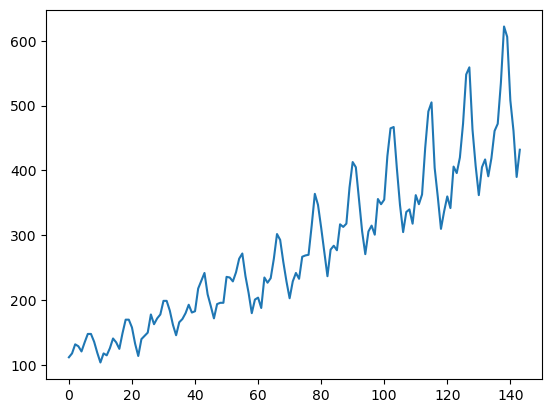

In [3]:
plt.plot(df['Passengers'])

In [4]:
#Is the data stationary?  

## method 1:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df['Passengers'])
#Not stationary...

## method 2:
#Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df['Passengers'])
print("pvalue = ", pvalue, " if above 0.05, data is not stationary") 


#Since data is not stationary, we may need SARIMA and not just ARIMA

pvalue =  0.991880243437641  if above 0.05, data is not stationary


In [5]:
df['Month'] = pd.to_datetime(df['Month'])

df.set_index('Month', inplace=True) #reset index to date
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<AxesSubplot:xlabel='month', ylabel='Passengers'>

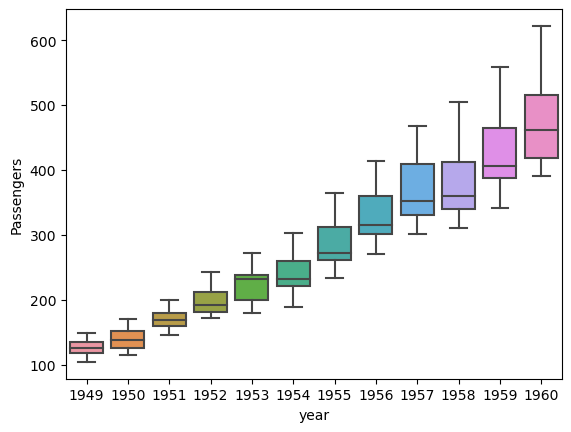

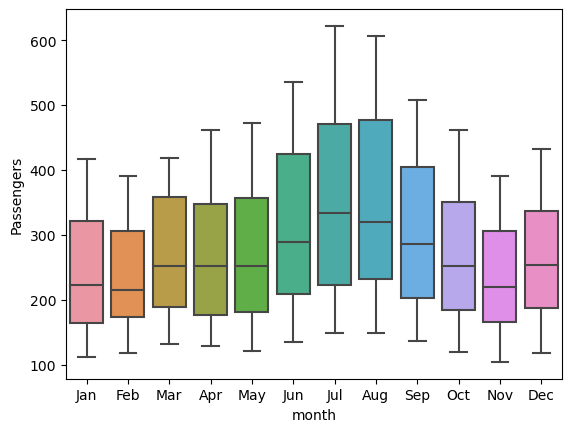

In [18]:
#  visualization

df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
years = df['year'].unique()

#Plot yearly and monthly values as boxplot
plt.figure()
sns.boxplot(x='year', y='Passengers', data=df)

plt.figure()
sns.boxplot(x='month', y='Passengers', data=df)


In [19]:
#Extract and plot trend, seasonal and residuals. 
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(df['Passengers'], model ='additive') #trend, seasonality, residual

#Additive time series:
#Value = Base Level + Trend + Seasonality + Error
#Multiplicative Time Series:
#Value = Base Level x Trend x Seasonality x Error

trend = decomposed.trend #5-values number, 
seasonal = decomposed.seasonal #Cyclic behavior may not be seasonal!
residual = decomposed.resid # residual yani baghimande

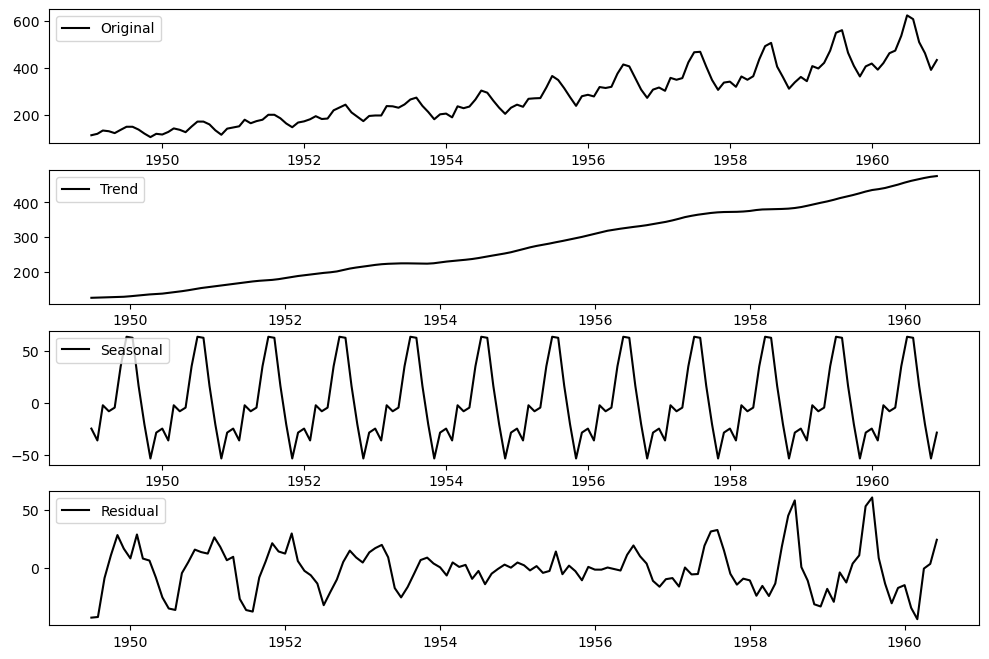

In [20]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df['Passengers'], label='Original', color='black')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='black')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='black')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='black')
plt.legend(loc='upper left')
plt.show()


# auto_arima model

In [ ]:
# model pyramid_auto_arima: 

from pmdarima.arima import auto_arima
# Autoarima gives us bet model suited for the data, by trying different values of parameters
# p - number of autoregressive terms (AR)
# q - Number of moving avergae terms (MA)
# d - number of non-seasonal differences
# p, d, q represent non-seasonal components
# P, D, Q represent seasonal components
arima_model = auto_arima(df['Passengers'], start_p = 1, d=1, start_q = 1,  #start e p,d,q
                          max_p = 5, max_q = 5, max_d=5, 
                          m = 12, 
                          start_P = 0, D=1, start_Q=0, 
                          max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, 
                          n_fits=50) #n_fit=epoches

# To print the summary 
print(arima_model.summary() ) #Note down the Model and details.
# Model: SARIMAX(0, 1, 1)x(2, 1, [], 12) --> in modele behinei ke tolid mishavad ba arima_model = auto_arima(...)

In [25]:
#Split data into train and test
size = int(len(df) * 0.70) 
X_train, X_test = df[0:size], df[size:]

In [28]:
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(X_train['Passengers'],  
                order = (0, 1, 1),  
                seasonal_order =(2, 1, 1, 12)) 
  
result = model.fit() 
result.summary() 

C:\Users\hkomi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hkomi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  100
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -317.196
Date:                            Thu, 16 Feb 2023   AIC                            644.391
Time:                                    09:55:06   BIC                            656.721
Sample:                                01-01-1949   HQIC                           649.356
                                     - 04-01-1957                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3287      0.097     -3.391      0.001      -0.519      -0.139
ar.S.L12       0.6791      0.441      1.541      0.123      -0.185       1.543
ar.S.L24       0.3201      0.110      2.899      0.004       0.104       0.536
ma.S.L12      -0.9828      4.772     -0.206      0.837     -10.336       8.371
sigma2        75.4174    327.683      0.230      0.818    -566.830     717.665
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.08
Prob(Q):                              0.98   Prob(JB):                         0.21
Heteroskedasticity (H):               1.29   Skew:                             0.46
Prob(H) (two-sided):                  0.50   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Month'>

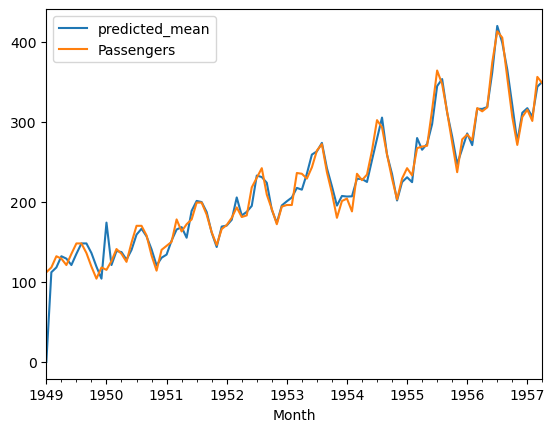

In [37]:
#prediction on train data
start_index = 0
end_index = len(X_train)-1
train_prediction = result.predict(start_index, end_index) 

# plot predictions and actual values 
train_prediction.plot(legend = True) 
X_train['Passengers'].plot(legend = True) 

<AxesSubplot:xlabel='Month'>

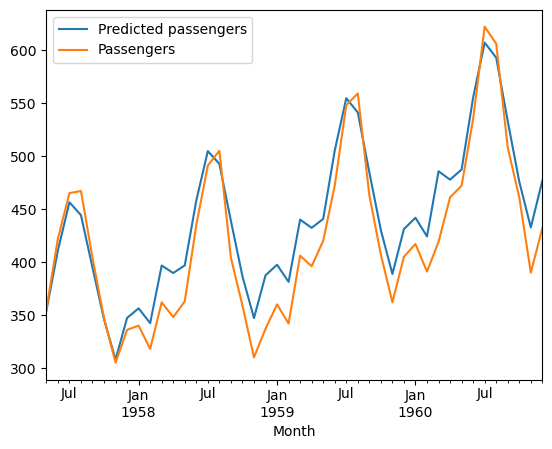

In [35]:
#Prediction on test data
start_index = len(X_train)
end_index = len(df)-1
prediction = result.predict(start_index, end_index).rename('Predicted passengers')  

# plot predictions and actual values 
prediction.plot(legend = True) 
X_test['Passengers'].plot(legend = True) 

In [41]:
# calculate root mean squared error, mse, for training and testing data:
import math
from sklearn.metrics import mean_squared_error


trainScore = math.sqrt(mean_squared_error(X_train['Passengers'], train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(X_test['Passengers'], prediction))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 15.80 RMSE
Test Score: 27.99 RMSE


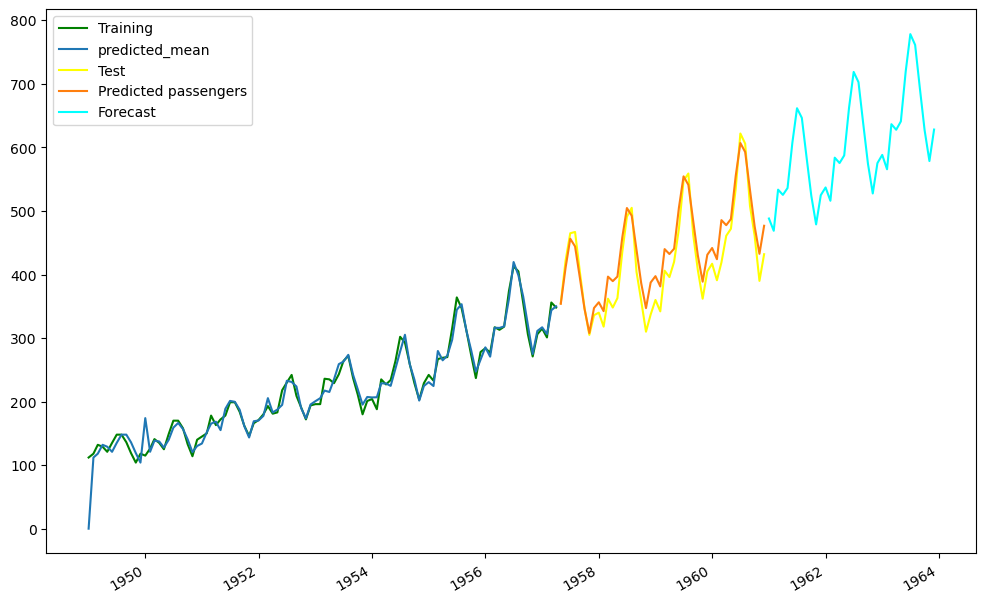

In [51]:
# forcast on future data:

forecast = result.predict(start = len(df),  
                          end = (len(df)-1) + 3 * 12,  
                          typ = 'levels').rename('Forecast') 
  
plt.figure(figsize=(12,8))
plt.plot(X_train['Passengers'], label='Train', color='green')
train_prediction.plot() 
plt.plot(X_test['Passengers'], label='Test', color='yellow')
prediction.plot() 
plt.plot(forecast, label='Forecast', color='cyan')
plt.legend()
plt.show()

#  Feedforward NN

In [187]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler #for normalization be raveshe min_max
from sklearn.metrics import mean_squared_error

In [188]:
df = pd.read_csv('database/AirPassengers.csv')
dataset = df['Passengers'].values
dataset = dataset.astype('float32').reshape(-1,1) #Convert values to float

In [189]:
dataset.shape

(144, 1)

In [190]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer, ba in ravesh maghadir beyne feature_range=(0, 1) map mishavand 
dataset = scaler.fit_transform(dataset)

In [191]:
# split into train and test sets
train_size = int(len(dataset) * 0.70)
print(train_size)

train, test = dataset[0:train_size], dataset[train_size:]

print(len(train))
print(len(test))

100
100
44


In [192]:
#  dataset matrix (X1,X2,X3,...,Xn)   --> (Xn+1)
#                 (X2,X3,X4,...,Xn+1) --> (Xn+2)


def to_sequences(data, seq_size=1): 
    x = []
    y = []

    for i in range(len(data)-seq_size):
        #print(i)
        window = data[i:(i+seq_size), 0]
        x.append(window)
        y.append(data[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

seq_size = 5 # Number of time steps to look back 


xtrain, ytrain = to_sequences(train, seq_size)
xtest,  ytest  = to_sequences(test, seq_size)


print("Shape of xtrain: {}".format(xtrain.shape))
print("Shape of ytrain: {}".format(ytrain.shape))

print("Shape of xtest : {}".format(xtest.shape))
print("Shape of ytest : {}".format(ytest.shape))

#Input dimensions are... (N x seq_size)

Shape of xtrain: (95, 5)
Shape of ytrain: (95,)
Shape of xtest : (39, 5)
Shape of ytest : (39,)


In [193]:
# create and fit dense model

model = Sequential()
model.add(Dense(64, input_dim=seq_size, activation='relu')) #12 / 8
model.add(Dense(32, activation='relu'))  #8
model.add(Dense(1))


model.compile(loss='mean_squared_error', optimizer='adam', metrics ='mae')
print(model.summary()) 


model.fit(xtrain, ytrain, validation_data=(xtest, xtest), epochs=100) # batch_size=2

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 64)                384       
                                                                 
 dense_34 (Dense)            (None, 32)                2080      
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
3/3 [==============================] - 2s 290ms/step - loss: 0.0362 - mae: 0.1597 - val_loss: 0.1349 - val_mae: 0.3468
Epoch 2/100
3/3 [==============================] - 0s 53ms/step - loss: 0.0185 - mae: 0.1072 - val_loss: 0.0665 - val_mae: 0.2317
Epoch 3/100
3/3 [==============================] 

In [154]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(80, 20)
(80,)
(24, 20)
(24,)


In [194]:
# make predictions
ytrainPred = model.predict(xtrain)
ytestPred = model.predict(xtest)

2/2 [==============================] - 0s 10ms/step


95
39
Train Score: 16.68 RMSE
Test Score: 36.70 RMSE


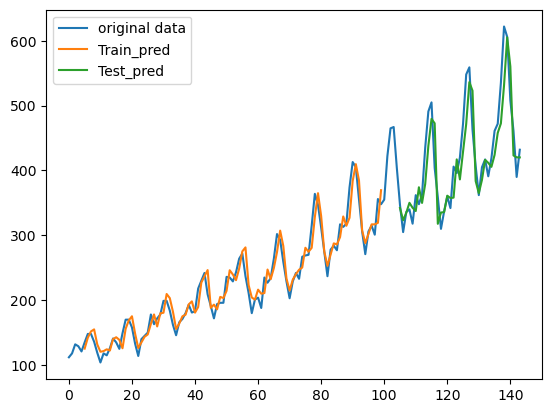

In [196]:
# Estimate model performance

ytrain_back_to_unscaled = scaler.inverse_transform([ytrain])
ytest_back_to_unscaled  = scaler.inverse_transform([ytest])

ytrainPred_back_to_unscaled = scaler.inverse_transform(ytrainPred)
ytestPred_back_to_unscaled  = scaler.inverse_transform(ytestPred)

print(len(ytrainPred_back_to_unscaled))
print(len(ytestPred_back_to_unscaled))

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(ytrain_back_to_unscaled[0], ytrainPred_back_to_unscaled[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(ytest_back_to_unscaled[0], ytestPred_back_to_unscaled[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
ytrainPredictPlot = np.empty_like(dataset)
ytrainPredictPlot[:] = np.nan
ytrainPredictPlot[seq_size:train_size] = ytrainPred_back_to_unscaled

# shift test predictions for plotting
ytestPredictPlot = np.empty_like(dataset)
ytestPredictPlot[:] = np.nan

#ytestPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1] = testPredict
ytestPredictPlot[train_size+seq_size:len(dataset)] = ytestPred_back_to_unscaled


# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='original data')
plt.plot(ytrainPredictPlot, label='Train_pred')
plt.plot(ytestPredictPlot, label='Test_pred')
plt.legend()
plt.show()

# Use TimeseriesGenerator 


In [158]:
#Use TimeseriesGenerator to organize training data into the right format
from keras.preprocessing.sequence import TimeseriesGenerator 

batch_size = 1
train_generator = TimeseriesGenerator(train.reshape(-1), train.reshape(-1), length=seq_size, batch_size=batch_size)

print("Total number of samples in the original training data = ", len(train)) # 95
print("Total number of samples in the generated data = ", len(train_generator)) # 75

#Also generate validation data
validation_generator = TimeseriesGenerator(test.reshape(-1), test.reshape(-1), length=seq_size, batch_size=batch_size)


Total number of samples in the original training data =  100
Total number of samples in the generated data =  80


In [159]:
model.fit(train_generator, epochs=100, validation_data=validation_generator)


# make predictions
ytrainPredict = model.predict(train_generator)
ytestPredict = model.predict(validation_generator)

Epoch 1/100
80/80 [==============================] - 4s 43ms/step - loss: 0.0013 - acc: 0.0000e+00 - val_loss: 0.0065 - val_acc: 0.0417
Epoch 2/100
80/80 [==============================] - 1s 10ms/step - loss: 9.0542e-04 - acc: 0.0000e+00 - val_loss: 0.0013 - val_acc: 0.0417
Epoch 3/100
80/80 [==============================] - 1s 10ms/step - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 0.0272 - val_acc: 0.0417
Epoch 4/100
80/80 [==============================] - 1s 10ms/step - loss: 0.0014 - acc: 0.0000e+00 - val_loss: 0.0011 - val_acc: 0.0417
Epoch 5/100
80/80 [==============================] - 1s 10ms/step - loss: 5.8648e-04 - acc: 0.0000e+00 - val_loss: 0.0068 - val_acc: 0.0417
Epoch 6/100
80/80 [==============================] - 1s 10ms/step - loss: 6.6876e-04 - acc: 0.0000e+00 - val_loss: 0.0013 - val_acc: 0.0417
Epoch 7/100
80/80 [==============================] - 1s 10ms/step - loss: 5.1421e-04 - acc: 0.0000e+00 - val_loss: 0.0049 - val_acc: 0.0417
Epoch 8/100
80/80 [=============

#  LSTM, RNN, Bidirectional(LSTM, ConvLSTM2D

In [201]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, Activation


# Reshape input to be [samples, time steps, features] 
trainX = np.reshape(xtrain, (xtrain.shape[0], 1, xtrain.shape[1])) 
testX =  np.reshape(xtest,  (xtest.shape[0],  1, xtest.shape[1]))

model = Sequential()
model.add(LSTM(64, input_shape=(1,trainX.shape[2])))
model.add(Dense(32))
model.add(Dense(1))


###########
'''
model = Sequential()
model.add(SimpleRNN(64, input_shape=(1,trainX.shape[2]), activation='relu')) #12
model.add(Dense(1))
'''


model.compile(optimizer='adam', loss='mean_squared_error', metrics='mae')
##monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, mode='auto', restore_best_weights=True)


model.fit(trainX, ytrain, validation_data=(testX, ytest), epochs=100)


# make predictions
ytrainPred = model.predict(trainX)
ytestPred = model.predict(testX)

Epoch 1/100
3/3 [==============================] - 11s 1s/step - loss: 0.0584 - mae: 0.2022 - val_loss: 0.2564 - val_mae: 0.4837
Epoch 2/100
3/3 [==============================] - 0s 63ms/step - loss: 0.0362 - mae: 0.1499 - val_loss: 0.1710 - val_mae: 0.3865
Epoch 3/100
3/3 [==============================] - 0s 62ms/step - loss: 0.0203 - mae: 0.1059 - val_loss: 0.1051 - val_mae: 0.2895
Epoch 4/100
3/3 [==============================] - 0s 60ms/step - loss: 0.0110 - mae: 0.0800 - val_loss: 0.0600 - val_mae: 0.1993
Epoch 5/100
3/3 [==============================] - 0s 58ms/step - loss: 0.0080 - mae: 0.0726 - val_loss: 0.0354 - val_mae: 0.1417
Epoch 6/100
3/3 [==============================] - 0s 63ms/step - loss: 0.0089 - mae: 0.0811 - val_loss: 0.0261 - val_mae: 0.1252
Epoch 7/100
3/3 [==============================] - 0s 62ms/step - loss: 0.0106 - mae: 0.0896 - val_loss: 0.0239 - val_mae: 0.1230
Epoch 8/100
3/3 [==============================] - 0s 71ms/step - loss: 0.0106 - mae: 0.089

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, Activation

#Reshape input to be [samples, time steps, features] 
trainX = np.reshape(xtrain, (xtrain.shape[0], 1, xtrain.shape[1])) 
testX =  np.reshape(xtest,  (xtest.shape[0],  1, xtest.shape[1]))

###################################################### model 1

'''
model = Sequential()
model.add(LSTM(64, input_shape=(1, xtrain.shape[1])))
model.add(Dense(32))
model.add(Dense(1))
'''

##################################################### model 2

'''
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, xtrain.shape[1]))) #
model.add(LSTM(50, activation='relu')) 
model.add(Dense(32))
model.add(Dense(1))
'''

########################################################### model 3
#SimpleRNN 

'''
model = Sequential()
model.add(SimpleRNN(64, input_shape=(1,xtrain.shape[1]), activation='relu')) 
model.add(Dense(1))
'''
#################################################### model 4
# Bidirectional LSTM # in ham forward ham backward dare
# sequence in both forward and backward directions
'''
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(1, xtrain.shape[1])))
model.add(Dense(1))
'''


######################################################### model 5
#ConvLSTM

# reshape of input data must be: [samples, timesteps, rows, columns, features]
''' 
trainX = xtrain.reshape((xtrain.shape[0], 1, 1, 1, xtrain.shape[1]))
testX = xtest.reshape((xtesX.shape[0], 1, 1, 1, xtrain.shape[1]))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, xtrain.shape[1])))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
'''


95
39
Train Score: 23.29 RMSE
Test Score: 48.03 RMSE


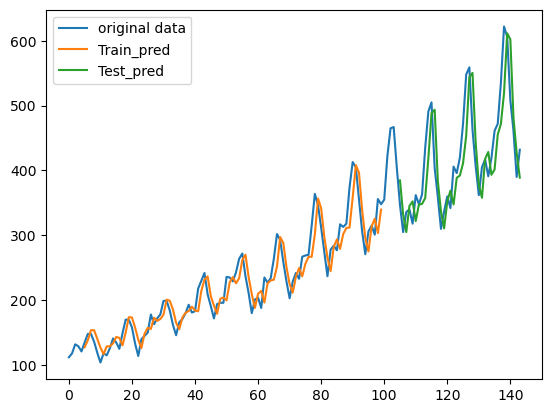

In [202]:
# Estimate model performance

# Since we used minmaxscaler we can now use scaler.inverse_transform to invert the transformation:


ytrain_back_to_unscaled = scaler.inverse_transform([ytrain])
ytest_back_to_unscaled  = scaler.inverse_transform([ytest])

ytrainPred_back_to_unscaled = scaler.inverse_transform(ytrainPred)
ytestPred_back_to_unscaled  = scaler.inverse_transform(ytestPred)

print(len(ytrainPred_inverse))
print(len(ytestPred_inverse))

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(ytrain_back_to_unscaled[0], ytrainPred_back_to_unscaled[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(ytest_back_to_unscaled[0], ytestPred_back_to_unscaled[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
ytrainPredictPlot = np.empty_like(dataset)
ytrainPredictPlot[:] = np.nan
ytrainPredictPlot[seq_size:train_size] = ytrainPred_back_to_unscaled

# shift test predictions for plotting
ytestPredictPlot = np.empty_like(dataset)
ytestPredictPlot[:] = np.nan

#ytestPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1] = testPredict
ytestPredictPlot[train_size+seq_size:len(dataset)] = ytestPred_back_to_unscaled


# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='original data')
plt.plot(ytrainPredictPlot, label='Train_pred')
plt.plot(ytestPredictPlot, label='Test_pred')
plt.legend()
plt.show()